<a href="https://colab.research.google.com/github/0x1beef/uap/blob/main/src/interlacing.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a href="https://kaggle.com/kernels/welcome?src=https://github.com/0x1beef/uap/blob/main/src/interlacing.ipynb">
    <img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Kaggle"   />
</a>

In [1]:
url = 'https://raw.githubusercontent.com/0x1beef/uap/main/src'
import os, urllib.request
for py_file in ['utils.py','common.py']:
    if not os.path.exists(py_file):
        urllib.request.urlretrieve(f'{url}/{py_file}', py_file)
import common

## **Create a test video**

In [2]:
import cv2
import numpy as np
import os

(w, h) = (480, 480)
step = 8
num_frames = 5 * step

back_colors = [60, 120]
def get_back_color(frame):
    back_color = back_colors[0]
    if frame == step or frame == step + 1:
        back_color = back_colors[1]
    if frame >= 2 * step:
        back_color = back_colors[1]
    if frame == 3 * step or frame == 3 * step + 1:
        back_color = back_colors[0]
    if frame >= 4 * step:
        back_color = back_colors[0]
    return back_color

bar_offsets = [100, 120]
def get_bar_offset(frame):
    bar_ofs = bar_offsets[0]
    if frame == step/2 or frame == step/2 + 1:
        bar_ofs = bar_offsets[1]
    if frame >= 2 * step - step / 2:
        bar_ofs = bar_offsets[1]
    if frame == 3 * step - step/2 or frame == 3 * step - step/2 + 1:
        bar_ofs = bar_offsets[0]
    if frame >= 4 * step - step / 2:
        bar_ofs = bar_offsets[0]
    return bar_ofs

def get_ellipse_rot_rect(frame):
    el_frame = int(frame/2)*2
    #el_frame = frame
    angle = (45 - el_frame * 3 / 2)
    period = 14; move_per_frame = 1
    loop_frame = period - abs(period - (el_frame % (2 * period)))
    x = w / 2 + loop_frame * move_per_frame - (period * move_per_frame / 2)
    y = h / 2 + (abs(period / 2 - loop_frame) - period / 2)
    return cv2.RotatedRect((x,y), (8, 25), angle) 

os.makedirs("test/in", exist_ok=True )
for frame in range(0, num_frames):
    mat = np.full((h,w), get_back_color(frame), np.uint8)
    bar_ofs = get_bar_offset(frame)
    for i in range(int(h / 4), int(3 * h / 4)):
        for j in range(0, 5):
            mat[i, int(w / 2) - bar_ofs + j] = 255
            mat[i, int(w / 2) + bar_ofs + j] = 255
    cv2.ellipse(mat, get_ellipse_rot_rect(frame), 0, -1)
    cv2.imwrite(f"test/in/test_{frame:04d}.png", mat)

In [3]:
import os;
#ENCODE='-c:v libx264 -preset veryslow -qp 0 -crf 0' # fully lossless video encoding
ENCODE='-c:v libx264 -codec h264 -preset veryslow -crf 1' # FireFox doesn't support fully lossless X264
INPUT_PNG='-start_number 0 -i test/in/test_%04d.png'
LOGS='-hide_banner -loglevel error'
# create a 2 FPS video
os.system(f'ffmpeg {LOGS} -r 2 {INPUT_PNG} -vf "format=yuv420p" {ENCODE} -r 2 -y test_vid.mp4')

0

## **Apply filters to simulate the effects in Gimbal**

\begin{align}
I_3(i,j,t) & =
  \begin{cases}
  I_2(i,j, 2 t+1) & \text {if $i$ is even, } \\
  I_2(i,j, 2 t) & \text { if $i$ is odd }
  \end{cases} \\
s(x) & = (x+0.5) \dfrac{480}{428} \\
I_2(i,j,t) & \approx \sum\limits_{(i_n,j_n) \in N(s(i),s(j))} c_h(j,j_n)c_v(i,i_n) I_1(i_n,j_n,t) \\
I_1(i,j,t) & =
  \begin{cases}
  I(i,j,t) & \text{if ($t$ is even and $i$ is even) or ($t$ is odd and $i$ is odd), } \\
  I(i,j,t+1) & \text{otherwise}
  \end{cases}
\end{align}

In [4]:
# using tinterlace filters (https://ffmpeg.org/ffmpeg-filters.html#tinterlace)
# that implement going from I to I1 and going from I2 to I3
INTERLACE_BOTTOM="tinterlace=interleave_bottom, tinterlace=interlacex2"
INTERLACE_TOP="tinterlace=interleave_top, tinterlace=interlacex2"
SCALE="scale=428:428:sws_flags=bilinear"
SELECT_EVEN="select='eq(mod(n,2),0)'" # drop every odd output frame
FULL_FILTERS=f"{INTERLACE_TOP}, {SCALE}, {INTERLACE_BOTTOM}, {SELECT_EVEN}"
ENCODE_WMV="-codec wmv1 -b:v 3M" # try to match the original quality
VID_FULL="test_vid_full.wmv"
# create a 1 FPS video from a 2 FPS input
os.system(f'ffmpeg {LOGS} -r 2 {INPUT_PNG} -vf "{FULL_FILTERS}" {ENCODE_WMV} -r 1 -y {VID_FULL}')
os.system(f'ffmpeg {LOGS} -i {VID_FULL} {ENCODE} -y test_vid_full.mp4')

SCALE_VERT="scale=iw:2*ih:sws_flags=neighbor"
FIELD_TOP="setfield=tff, field=0" # make sure the field dominance is set to 'tff' to get consistent results
FIELD_BOTTOM="setfield=tff, field=1"
os.system(f'ffmpeg {LOGS} -i {VID_FULL} -vf "{FIELD_TOP}, {SCALE_VERT}" {ENCODE} -y test_vid_full_top.mp4')
os.system(f'ffmpeg {LOGS} -i {VID_FULL} -vf "{FIELD_BOTTOM}, {SCALE_VERT}" {ENCODE} -y test_vid_full_bottom.mp4')

os.makedirs("test/out", exist_ok=True )
os.system(f'ffmpeg {LOGS} -i {VID_FULL} -start_number 0 test/out/frame_%04d.png')

0

## **Compare the results to Gimbal**

In [5]:
gimbal = common.gimbal_from_huggingface(verbose = False)

gimbal/2 - GIMBAL.wmv:   0%|          | 0.00/13.5M [00:00<?, ?B/s]

ffmpeg -hide_banner -loglevel error -i "gimbal/2 - GIMBAL.wmv" -vf "format=gray, crop=428:428:104:27:exact=1" -vsync vfr -start_number 0 gimbal/frame_%04d.png
'gimbal': 1031 frames @ 29.97 fps


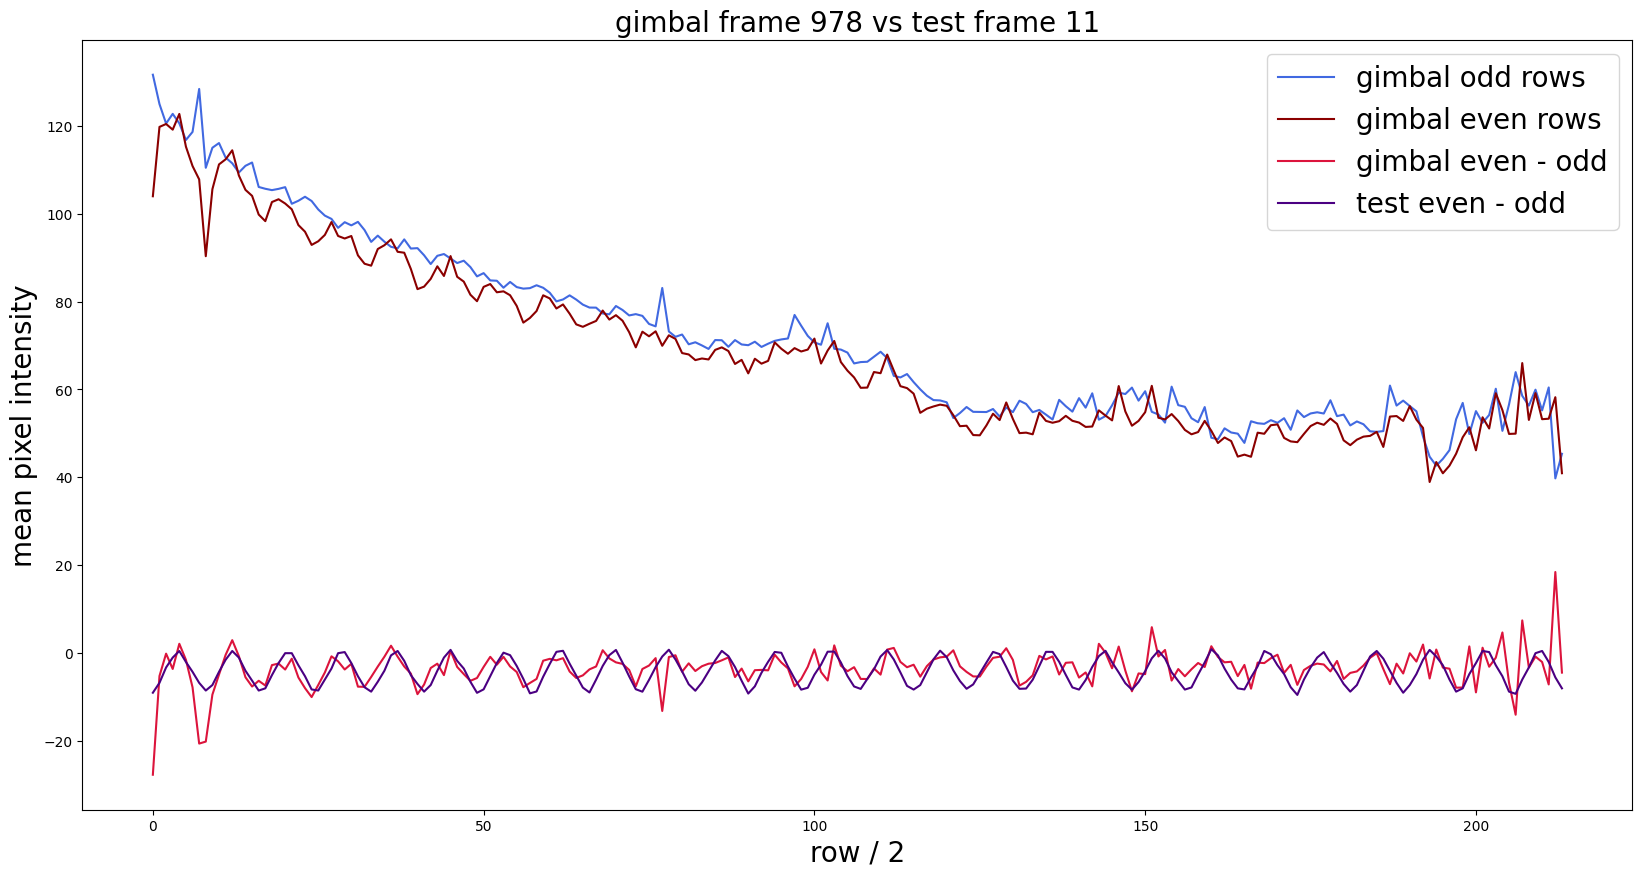

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

gimbal_frame=978
#gimbal_frame=371
#gimbal_frame=979
#gimbal_frame=1020
#gimbal_frame=1021

test_frame = 11 if gimbal_frame % 2 == 0 else 12

mat = cv2.imread(f"gimbal/frame_{gimbal_frame:04d}.png", cv2.IMREAD_GRAYSCALE)
mat_test = cv2.imread(f"test/out/frame_{test_frame:04d}.png", cv2.IMREAD_GRAYSCALE)
(h, w) = mat.shape
rows = range(0,h,2)
cols = slice(0,w)
#cols = slice(int(w/2)+20,w)
#cols = slice(0,int(w/2)-20)

gimbal_odd = [np.mean(mat[i+1, cols]) for i in rows]
gimbal_even = [np.mean(mat[i, cols]) for i in rows]
gimbal_diff = [np.mean(mat[i, cols]) - np.mean(mat[i+1, cols]) for i in rows]

scale=4
shift=3 if gimbal_frame % 2 == 0 else -3
#todo: the test diff is scaled and shifted to match, so this only tests frequency not amplitude
test_diff = [(np.mean(mat_test[i, cols]) - np.mean(mat_test[i+1, cols]))/scale+shift for i in rows]

plt.figure(figsize=(20,10))
plt.title(f"gimbal frame {gimbal_frame} vs test frame {test_frame}", fontsize=20)
plt.plot(gimbal_odd, color='royalblue', label='gimbal odd rows')
plt.plot(gimbal_even, color='darkred', label='gimbal even rows')
plt.plot(gimbal_diff, color='crimson', label='gimbal even - odd')
plt.plot(test_diff, color='indigo', label='test even - odd')
plt.xlabel("row / 2", fontsize=20)
plt.ylabel("mean pixel intensity", fontsize=20)
plt.legend(fontsize=20)
#plt.savefig('plot_bands.png')
plt.show()

## **Create videos to illustrate the artifacts**

In [7]:
!pip -q install mediapy

In [8]:
import cv2
import numpy as np
import mediapy as media
from dataclasses import dataclass
from enum import IntFlag

@dataclass
class Roi: # the bounds of a region of interest that will be cropped
    top:int; bottom: int; left:int; right: int

# add a label to an image. negative coordinates are relative to the height/width
def image_label(img, label, pos):
    (rows,cols) = img.shape; (y,x) = pos
    font = cv2.FONT_HERSHEY_SIMPLEX; scale = 1; color = 255
    (text_w, text_h), baseLine = cv2.getTextSize(label, font, scale, 1)
    y = rows + y if y < 0 else y + text_h
    x = cols - text_w + x if x < 0 else x
    cv2.putText(img, label, (x, y), font, scale, color)

# crop, resize and label a frame with the frame number
def get_frame(mat, roi: Roi, resize_factor, frame, label_pos = (-2, 1)):
    mat_out = mat[roi.top:roi.bottom, roi.left:roi.right]
    mat_out = cv2.resize(mat_out, (0,0), fx = resize_factor, fy = resize_factor, interpolation = cv2.INTER_NEAREST)
    image_label(mat_out, f'{frame}', label_pos)
    return mat_out

# crop, resize and label the top/bottom fields of a given frame
def get_fields(mat, roi : Roi, resize_factor, frame, label_pos = (-2, 1)):
    mat_top = mat[roi.top:roi.bottom:2, roi.left:roi.right]
    mat_bottom = mat[roi.top+1:roi.bottom+1:2, roi.left:roi.right]
    # duplicate every other row to keep the aspect ratio
    def resize(mat, fxy) :
        return cv2.resize(mat, (0,0), fx = fxy, fy = 2 * fxy, interpolation = cv2.INTER_NEAREST)
    mat_top = resize(mat_top, resize_factor)
    mat_bottom = resize(mat_bottom, resize_factor)
    image_label(mat_top, f'{frame} T', label_pos)
    image_label(mat_bottom, f'{frame} B', label_pos)
    return (mat_top, mat_bottom)

class Fields(IntFlag):
    TOP = 1, # just the top field
    BOTTOM = 2, # just the bottom field
    IN_ORDER = 3, # both fields in sequence, in NTSC temporal order
    FULL = 4 # the full frame

def append_fields(frame_list, mat_top_bottom, fields = Fields.IN_ORDER):
    (mat_top, mat_bottom) = mat_top_bottom
    if fields & Fields.BOTTOM != 0:
        frame_list.append(mat_bottom)
    if fields & Fields.TOP != 0:
        frame_list.append(mat_top)

def get_full_roi(mat):
    (rows,cols) = mat.shape
    return Roi(top = 0, bottom = rows, left = 0, right = cols)

def make_video(video_name, frame_path, frame_range, roi_func = None, resize_factor = 1,
               fields = Fields.IN_ORDER, label_pos=(-2, 1), fps=1, crf=0, file_type="mp4"):
    frame_list = []
    for frame in frame_range:
        mat = cv2.imread(f"{frame_path}/frame_{frame:04d}.png", cv2.IMREAD_GRAYSCALE)
        roi = get_full_roi(mat) if roi_func is None else roi_func(mat.shape[0], mat.shape[1])
        if fields == Fields.FULL:
            frame_list.append(get_frame(mat, roi, resize_factor, frame, label_pos))
        else:
            append_fields(frame_list, get_fields(mat, roi, resize_factor, frame, label_pos), fields)
    codec = "h264"
    if file_type == "gif":
        codec = "gif"
    video_file = f"{video_name}.{file_type}"
    media.write_video(video_file, np.array(frame_list), fps=fps, codec=codec, crf=crf)
    media.show_video(media.read_video(video_file))

def roi_func_central(roi_factor):
    # make sure these offsets start from an even number for top/bottom to be right
    roi_ofs = lambda dim, sign: int((dim/2 + sign * dim/roi_factor)/2)*2
    return lambda rows, cols: Roi(top = roi_ofs(rows,-1), bottom = roi_ofs(rows,1),
        left = roi_ofs(cols,-1), right = roi_ofs(cols,1));

make_video("gimbal_field_order", "gimbal", range(999,1005), 
           label_pos=(-2, 1), fps=2, file_type="gif",
           resize_factor = 2, roi_func = roi_func_central(8))
    
make_video("switch_field_order", "gimbal", range(370, 373), 
           label_pos=(1,-1), fps=1, crf=20)

make_video("test_field_order", "test/out", range(0, 18),
           label_pos=(1,1), fps=2, crf=1)

def roi_func_factor(v_range = (0,1), h_range = (0,1)):
    (from_v, to_v) = v_range; (from_h, to_h) = h_range
    return lambda rows, cols: Roi(top = int(from_v*rows/2)*2, bottom = int(to_v*rows),
        left = int(from_h*cols), right = int(to_h*cols))

make_video("desync_1020", "gimbal", range(1019, 1023), fields = Fields.BOTTOM,
           label_pos = (1,1), fps=1, crf=1,
           resize_factor = 2, roi_func = roi_func_factor(v_range=(3/4,1)))

make_video("desync_345", "gimbal", range(344, 348),fields = Fields.BOTTOM,
           label_pos = (1,1), fps=1, crf=1,
           resize_factor = 2, roi_func = roi_func_factor(v_range=(3/4,1)))

make_video("desync_27", "gimbal", range(25, 29),fields = Fields.BOTTOM,
           label_pos = (1,1), fps=1, crf=1,
           resize_factor = 2, roi_func = roi_func_factor(v_range=(3/4,1)))

In [9]:
f=345
os.system(f"ffmpeg -i desync_{f}.mp4 -vf 'eq=gamma=1' {ENCODE} -y desync_{f}_filtered.mp4 >/dev/null 2>&1")
media.show_video(media.read_video(f'desync_{f}_filtered.mp4'))

In [10]:
gofast = common.gofast_from_huggingface(verbose = False)
    
make_video("gofast_switch", "gofast", range(635,639), 
           label_pos=(1,-1), fps=2, crf=1)

make_video("gofast_switch_2", "gofast", range(782,785), 
           label_pos=(1,-1), fps=2, crf=1)

gofast/3 - GOFAST.wmv:   0%|          | 0.00/13.5M [00:00<?, ?B/s]

ffmpeg -hide_banner -loglevel error -i "gofast/3 - GOFAST.wmv" -vf "format=gray, crop=428:428:104:27:exact=1" -vsync vfr -start_number 0 gofast/frame_%04d.png
'gofast': 1031 frames @ 29.97 fps


In [11]:
flir1 = common.flir1_from_huggingface(verbose = False)

make_video("flir1_artifacts", "flir1", range(1237, 1243), fields=Fields.FULL,
           label_pos=(1,-1), fps=1, crf=1)

flir1/1 - FLIR.mp4:   0%|          | 0.00/5.62M [00:00<?, ?B/s]

ffmpeg -hide_banner -loglevel error -i "flir1/1 - FLIR.mp4" -vf "format=gray, crop=240:238:54:15:exact=1" -vsync vfr -start_number 0 flir1/frame_%04d.png
'flir1': 2288 frames @ 30.00 fps
